In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
try:
    from rich.progress import track
except:
    track = lambda x: x

from numpy.random import default_rng
rng = default_rng()

## Relaxation solution to Laplace’s equation

We have developed an approach to solving Laplace’s equation using separation of variables, which yields solutions in the form of sums of products of a function of $x$ times a function of $y$. When we solved Laplace’s equation for the potential $V(x,y)$ in a square of side $L$ that had three grounded sides and the fourth side, at $y=L$ held at $V_0$, we found
\begin{equation}\label{eq:Lapl2}
    V(x,y) = 4 V_0 \sum_{n\text{ odd}} \frac{1}{n \pi \sinh(n\pi)} \sin\left(\frac{n \pi x}{L}\right) \sinh\left(\frac{n\pi y}{L}\right)
\end{equation}

Here, we explore an entirely numerical approach to solving this problem that relies on approximating the derivatives with finite differences.

By definition,
$$
    \frac{\partial V}{\partial x} = \lim_{\Delta x \to 0} \frac{V(x+\Delta x, y) - V(x, y)}{\Delta x}
$$
The finite-difference approach to approximating derivatives is to make $\Delta x$ small but finite. If we discretize the area using
$$
    x_j = j\,\Delta x \qquad\text{and}\qquad y_i = i\,\Delta y
$$
then
$$
    \frac{\partial V}{x} \approx \frac{V_{i,j+1} - V_{i,j}}{\Delta x}
$$
is an approximation to the value at $x_j + \frac12 \Delta x$. To get the second derivative, we use the same strategy again:
$$
    \frac{\partial^2 V}{\partial x^2} \approx \frac{
        \displaystyle\frac{V_{i,j+1}-V_{i,j}}{\Delta x} - \frac{V_{i,j}-V_{i,j-1}}{\Delta x}}{\Delta x}
    = \frac{V_{i,j+1} - 2 V_{i,j} + V_{i,j-1}}{(\Delta x)^2}
$$
If we use a square grid, so that $\Delta x = \Delta y$, then
$$
\frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} \approx \frac{V_{i,j+1} + V_{i,j-1} + V_{i+1,j} + V_{i-1,j} - 4V_{i,j}}{(\Delta x)^2} = 0
$$
Rearranging slightly, we get
\begin{equation}\label{eq:average}
  V_{i,j} = \frac{1}{4}\left( V_{i+1,j} + V_{i-1,j} + V_{i,j+1} + V_{i,j-1} \right)
\end{equation}
In other words, the potential at $[i,j]$ is equal to the average of the four nearest neighbor values along the cardinal directions. Let's see how we can use this to **relax** an initial configuration towards a solution that agrees with the average of its neighbors.

In [3]:
class TwoDLapl:
    def __init__(self, N:int, **kwargs):
        self.V = np.empty((N,N), dtype=np.float64)
        self.N = N
        self.N1 = N-1
        self.N2 = N-2
        self.shift = []
        self.im = None
        self.reset()
        self.SOR = kwargs.get('SOR', 1.0)
        self.order = self.set_order(**kwargs)
        self.alternate = kwargs.get('alternate', False)
        self.fig, (self.axim, self.axline) = plt.subplots(
            ncols=2, figsize=(12,6),
            gridspec_kw=dict(width_ratios=(2,1)))
        self.im = self.axim.matshow(self.V, cmap='Spectral', origin='lower', extent=(0,1,0,1))
        plt.colorbar(self.im, shrink=0.75)

    def reset(self):
        self.V[:,:] = 0.0
        self.V[self.N1,:] = 1.0
        self.shift = []

    def relax(self):
        self.dVmax = 0.0
        V = self.V

        def update(r, c):
            newV = (V[r+1,c] + V[r-1,c] + V[r,c+1] + V[r,c-1]) / 4
            dV = newV - V[r,c]
            self.dVmax = max(self.dVmax, abs(dV))
            V[r,c] += self.SOR * dV

        if self.alternate:
            o = self.order if len(self.shift) % 2 else reversed(self.order)
        else:
            o = self.order

        for r,c in o:
            update(r, c)

        self.shift.append(self.dVmax)
    
    def set_order(self, **kwargs):
        """Create a list of the (r,c) pairs to update"""
        interior = np.arange(1, self.N1, dtype=np.uint32)
        X, Y = np.meshgrid(interior, interior)
        allpairs = [(x,y) for x,y in zip(X.flatten(), Y.flatten())]
        
        if kwargs.get('random', False):
            allpairs = np.array(allpairs)
            rng.shuffle(allpairs)
        
        return tuple(allpairs)

    def show(self):
        self.im.set_data(self.V)
        self.axline.clear()
        self.axline.semilogy(np.arange(len(self.shift)), self.shift)
        self.axline.set_ylabel("abs(shift)")
        self.axline.set_xlabel("iteration")
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

    def showrelax(self, N:int, update:int):
        for n in track(range(N)):
            self.relax()
            if (n+1) % update == 0:
                self.show()

<IPython.core.display.Javascript object>


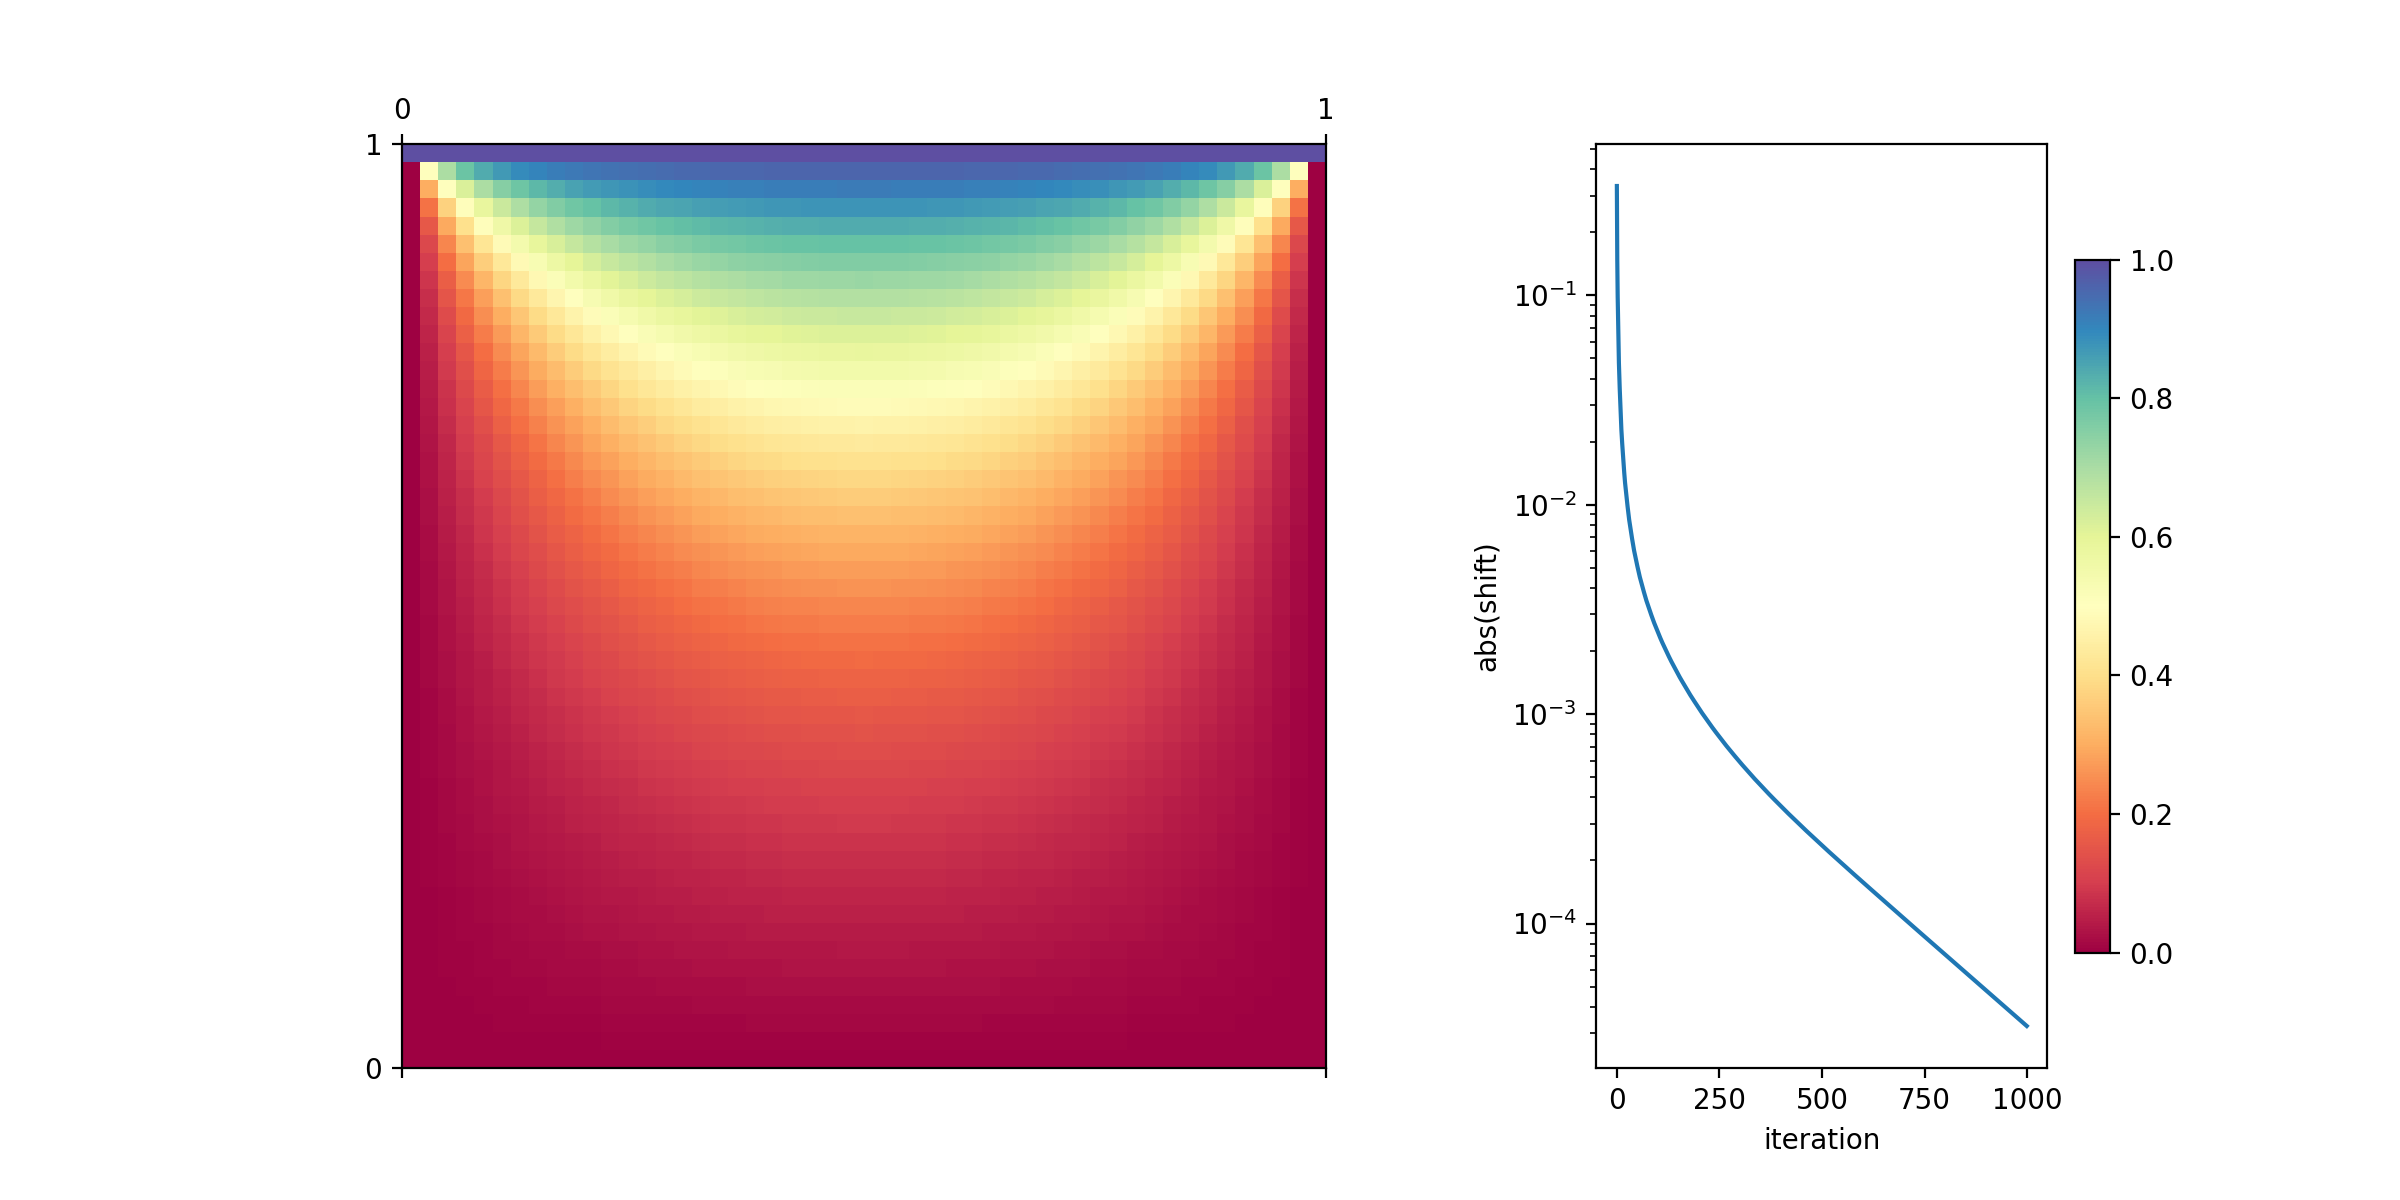

In [4]:
plt.close('all')
d = TwoDLapl(51)

In [5]:
d.showrelax(1000,50)

<IPython.core.display.Javascript object>


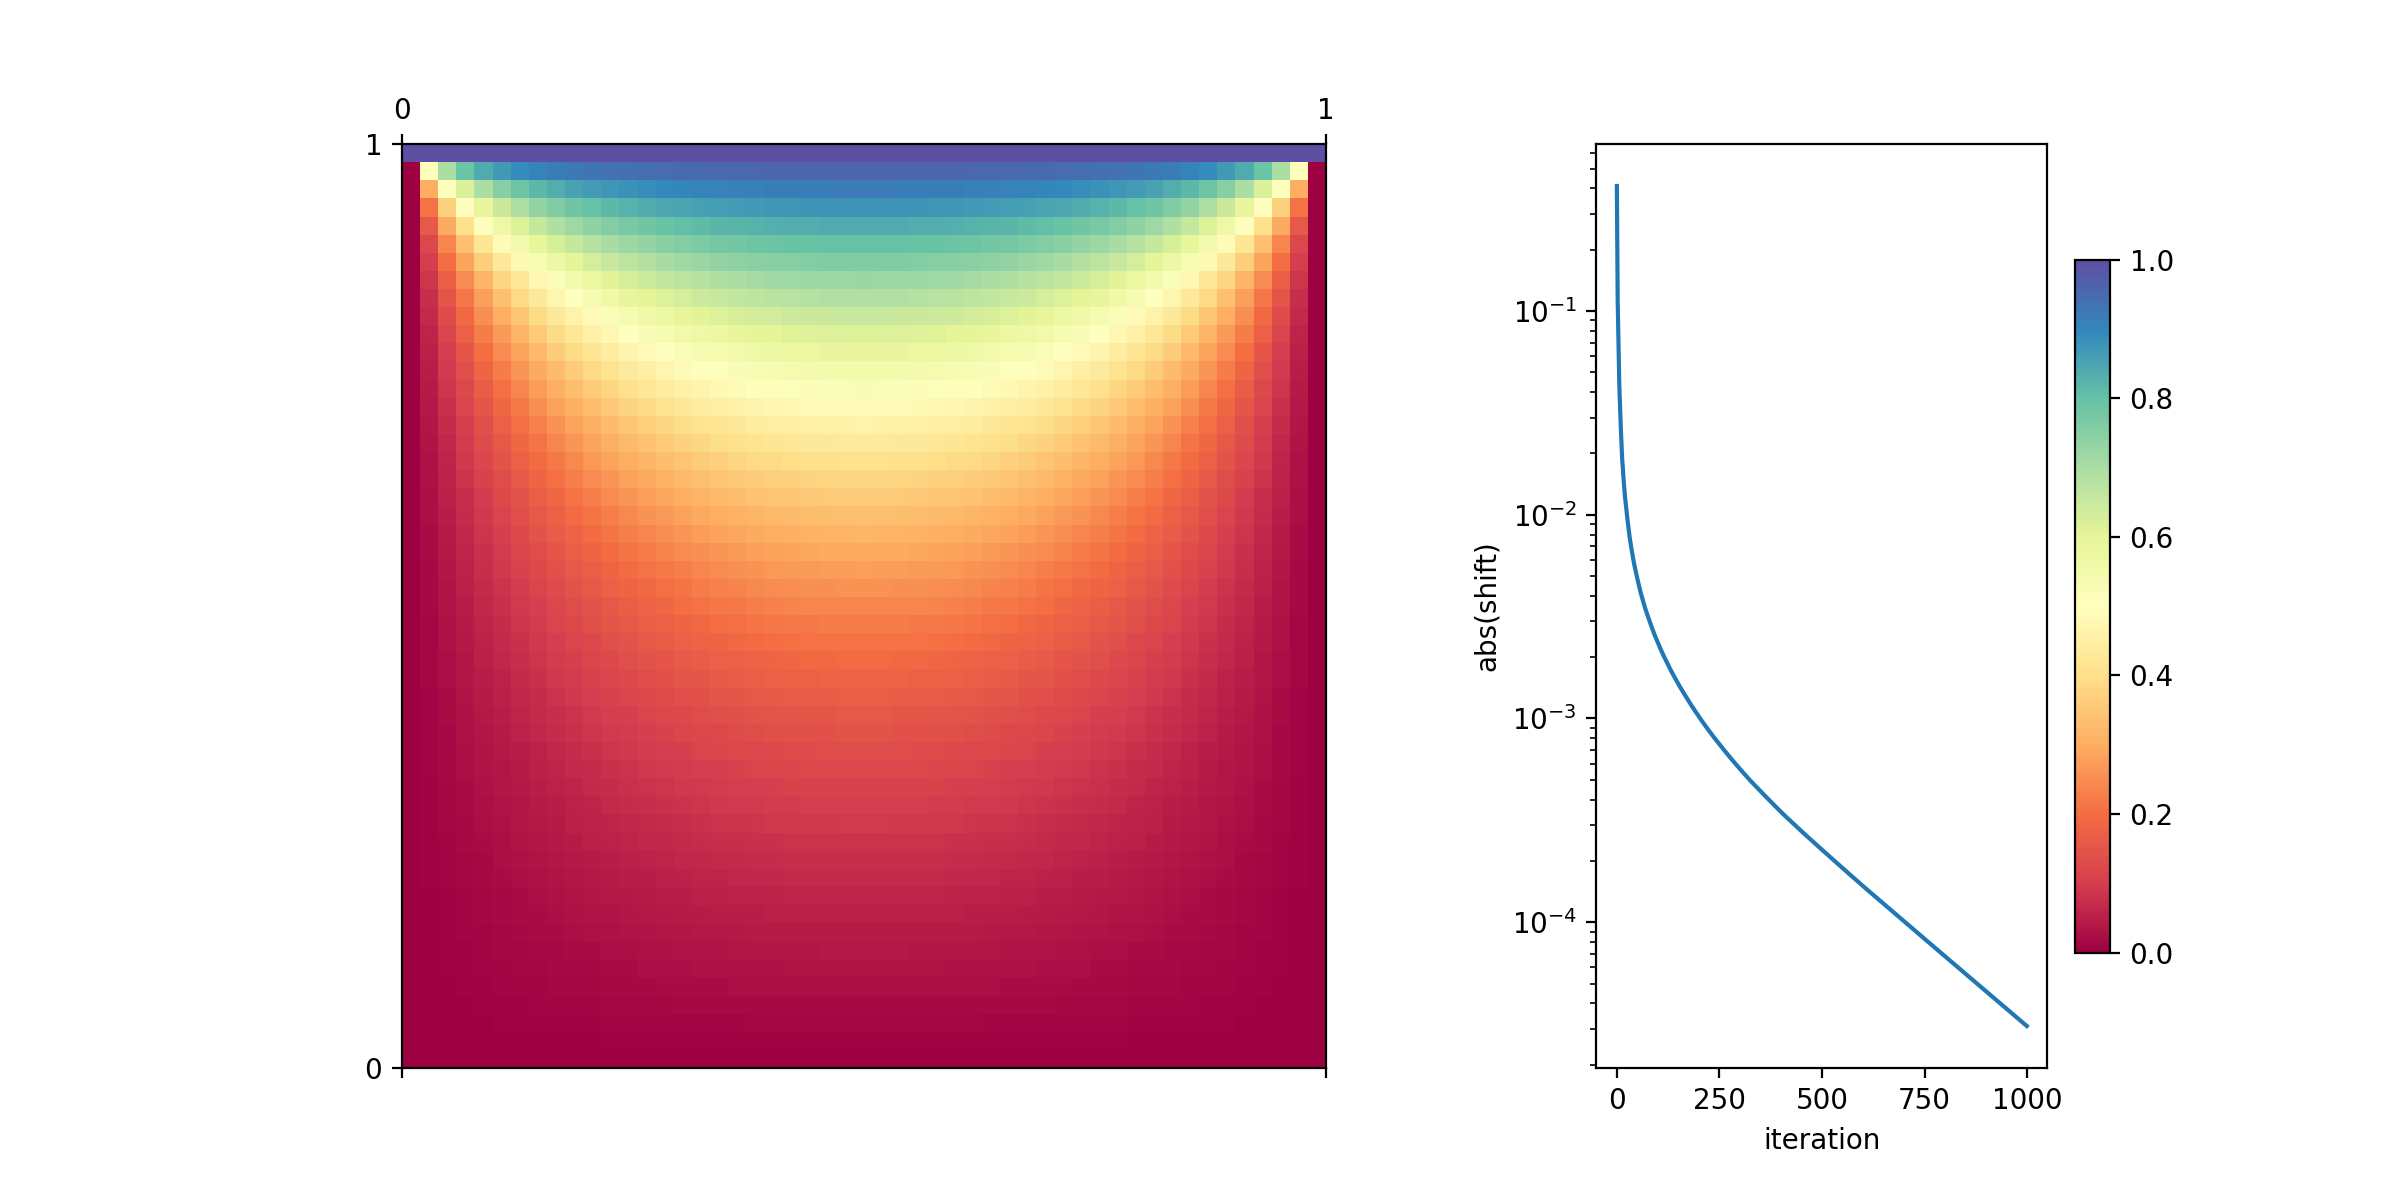

In [6]:
dd = TwoDLapl(51, random=True)

In [7]:
dd.showrelax(1000,100)

<IPython.core.display.Javascript object>


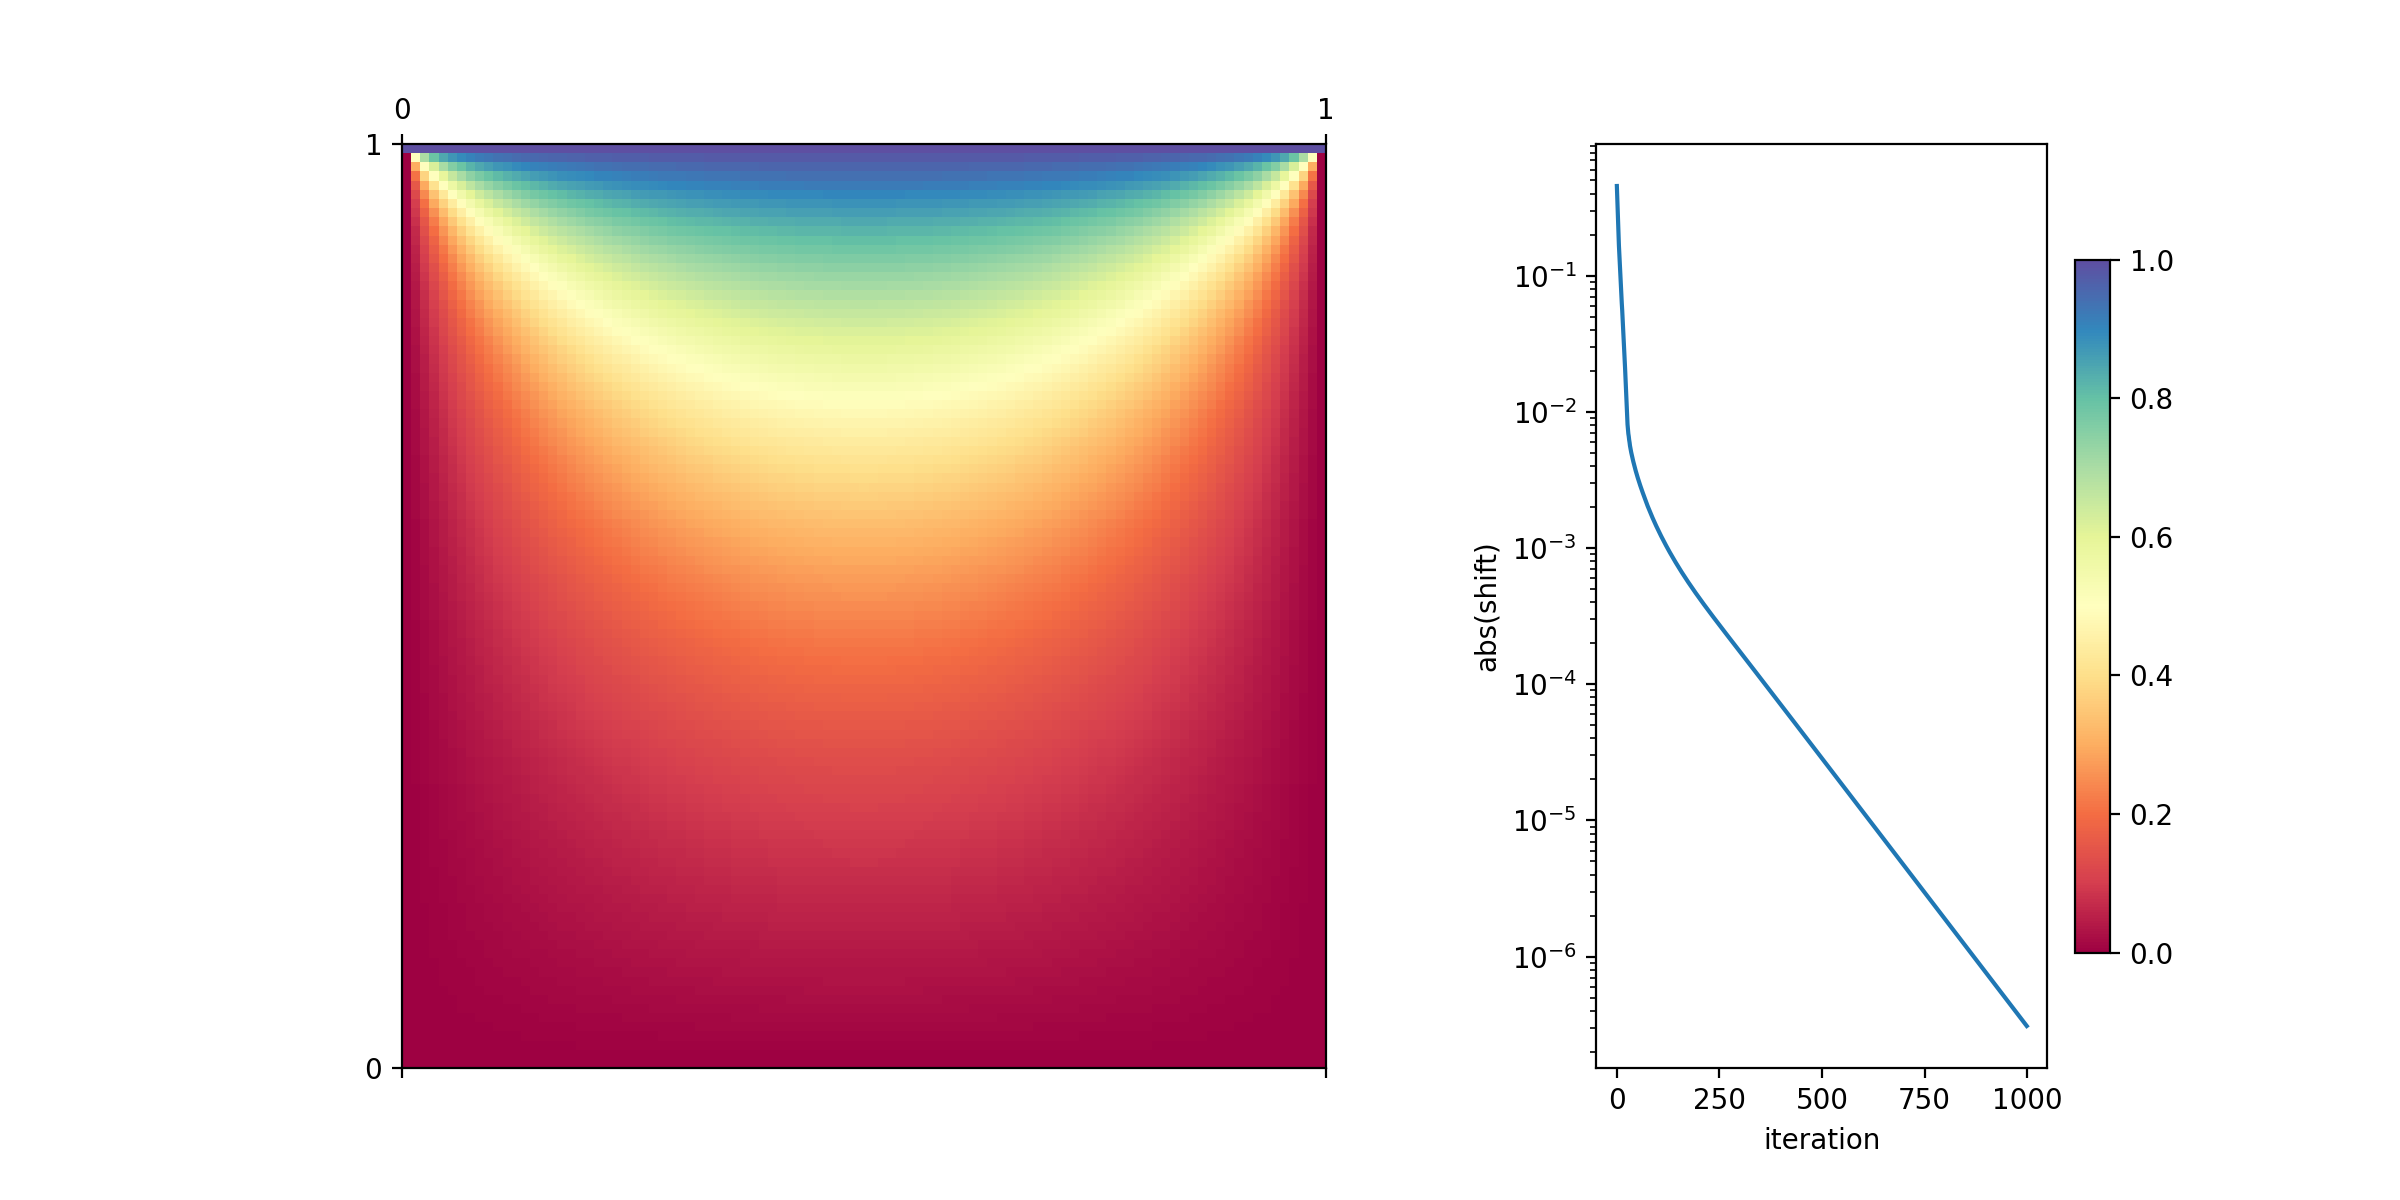

In [8]:
dSOR = TwoDLapl(101, SOR=1.8)

In [9]:
dSOR.showrelax(1000,100)

<IPython.core.display.Javascript object>


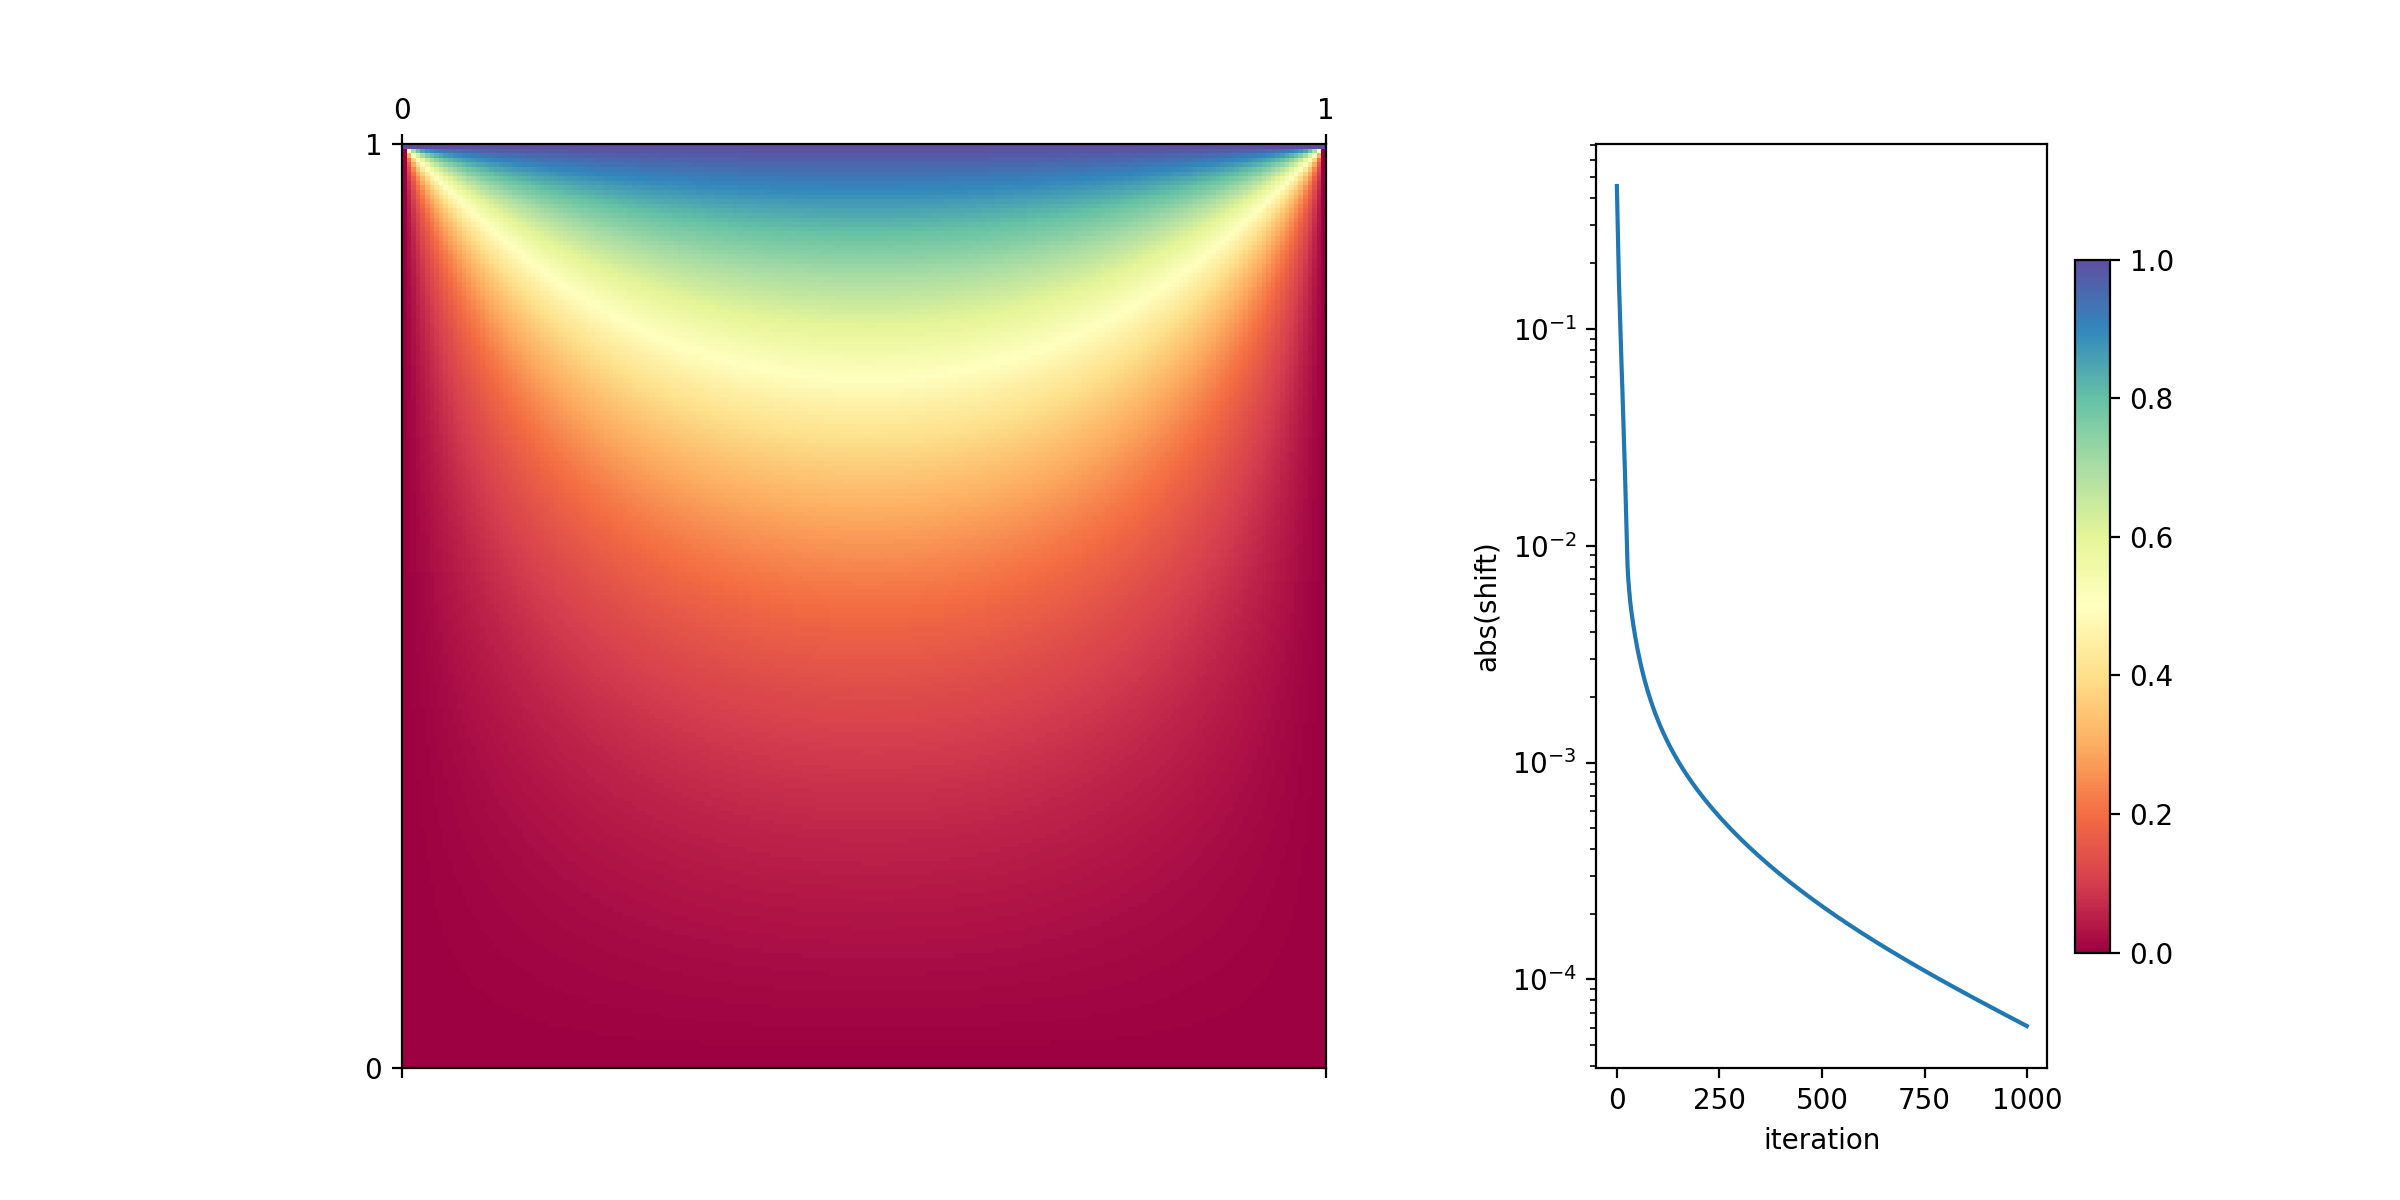

In [10]:
dbig = TwoDLapl(201, SOR=1.8)

In [11]:
dbig.showrelax(1000,100)